In [ ]:
import os
import cv2
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [ ]:
class UCF101Dataset(Dataset):
    def __init__(self, root_dir, transform=None, max_videos=100):
        self.root_dir = root_dir
        self.transform = transform
        self.video_paths = []

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.avi', '.mp4')):
                    self.video_paths.append(os.path.join(root, file))
        self.video_paths = self.video_paths[:max_videos]

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(Image.fromarray(frame))
        cap.release()

        if len(frames) == 0:
            raise ValueError(f"No frames in video: {video_path}")

        frame = random.choice(frames)
        frame_np = np.array(frame)

        # --- Degradation: blur + black patches + noise ---
        degraded_np = cv2.GaussianBlur(frame_np, (7, 7), 0)
        h, w, _ = degraded_np.shape
        for _ in range(random.randint(3, 6)):
            ph, pw = random.randint(20, 60), random.randint(20, 60)
            px, py = random.randint(0, w - pw), random.randint(0, h - ph)
            degraded_np[py:py+ph, px:px+pw, :] = 0
        noise = np.random.normal(0, 10, degraded_np.shape).astype(np.float32)
        degraded_np = np.clip(degraded_np + noise, 0, 255).astype(np.uint8)
        degraded = Image.fromarray(degraded_np)

        if self.transform:
            degraded = self.transform(degraded)
            frame = self.transform(frame)

        return degraded, frame


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

root_dir = "/content/drive/MyDrive/UCF101/UCF-101"  # Change to your dataset path
dataset = UCF101Dataset(root_dir, transform=transform, max_videos=100)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.BatchNorm2d(64), # Added BatchNorm
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128), # Added BatchNorm
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), # Added BatchNorm
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 0), nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion_gan = nn.BCELoss()
criterion_l1 = nn.L1Loss()

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
epochs = 50

for epoch in range(epochs):
    for i, (degraded, original) in enumerate(dataloader):
        degraded, original = degraded.to(device), original.to(device)
        # Get the shape of the discriminator's output
        with torch.no_grad():
          discriminator_output_shape = discriminator(degraded).shape

        # Create valid and fake tensors with the same shape as the discriminator's output
        valid = torch.ones(discriminator_output_shape, device=device)
        fake = torch.zeros(discriminator_output_shape, device=device)

        # Generator
        optimizer_g.zero_grad()
        restored = generator(degraded)
        pred_fake = discriminator(restored)
        loss_g = criterion_gan(pred_fake, valid) + 100 * criterion_l1(restored, original)
        loss_g.backward()
        optimizer_g.step()

        # Discriminator
        optimizer_d.zero_grad()
        pred_real = discriminator(original)
        pred_fake = discriminator(restored.detach())
        loss_d = (criterion_gan(pred_real, valid) + criterion_gan(pred_fake, fake)) / 2
        loss_d.backward()
        optimizer_d.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss_D: {loss_d.item():.4f} | Loss_G: {loss_g.item():.4f}")

torch.save(generator.state_dict(), "generator.pth")
print("✅ Training complete! Model saved as 'generator.pth'")

Epoch [1/50] | Loss_D: 0.6589 | Loss_G: 25.0114
Epoch [2/50] | Loss_D: 0.6873 | Loss_G: 16.8620
Epoch [3/50] | Loss_D: 0.6643 | Loss_G: 14.9988
Epoch [4/50] | Loss_D: 0.6552 | Loss_G: 17.4571
Epoch [5/50] | Loss_D: 0.6695 | Loss_G: 17.4406
Epoch [6/50] | Loss_D: 0.6419 | Loss_G: 19.2761
Epoch [7/50] | Loss_D: 0.6718 | Loss_G: 13.6986
Epoch [8/50] | Loss_D: 0.6836 | Loss_G: 11.0638
Epoch [9/50] | Loss_D: 0.6554 | Loss_G: 13.6440
Epoch [10/50] | Loss_D: 0.6478 | Loss_G: 13.2118
Epoch [11/50] | Loss_D: 0.6807 | Loss_G: 16.4394
Epoch [12/50] | Loss_D: 0.6613 | Loss_G: 11.9548
Epoch [13/50] | Loss_D: 0.6228 | Loss_G: 16.5420
Epoch [14/50] | Loss_D: 0.6729 | Loss_G: 15.7346
Epoch [15/50] | Loss_D: 0.6234 | Loss_G: 15.0292
Epoch [16/50] | Loss_D: 0.6398 | Loss_G: 14.8734
Epoch [17/50] | Loss_D: 0.6369 | Loss_G: 11.3327
Epoch [18/50] | Loss_D: 0.6264 | Loss_G: 14.0448
Epoch [19/50] | Loss_D: 0.6528 | Loss_G: 12.9201
Epoch [20/50] | Loss_D: 0.6207 | Loss_G: 11.9181
Epoch [21/50] | Loss_D: 0.631

In [ ]:
def denorm(img_tensor):
    img = img_tensor.cpu().squeeze(0) * 0.5 + 0.5
    img_np = np.transpose(img.numpy(), (1, 2, 0))
    return np.clip(img_np, 0, 1)


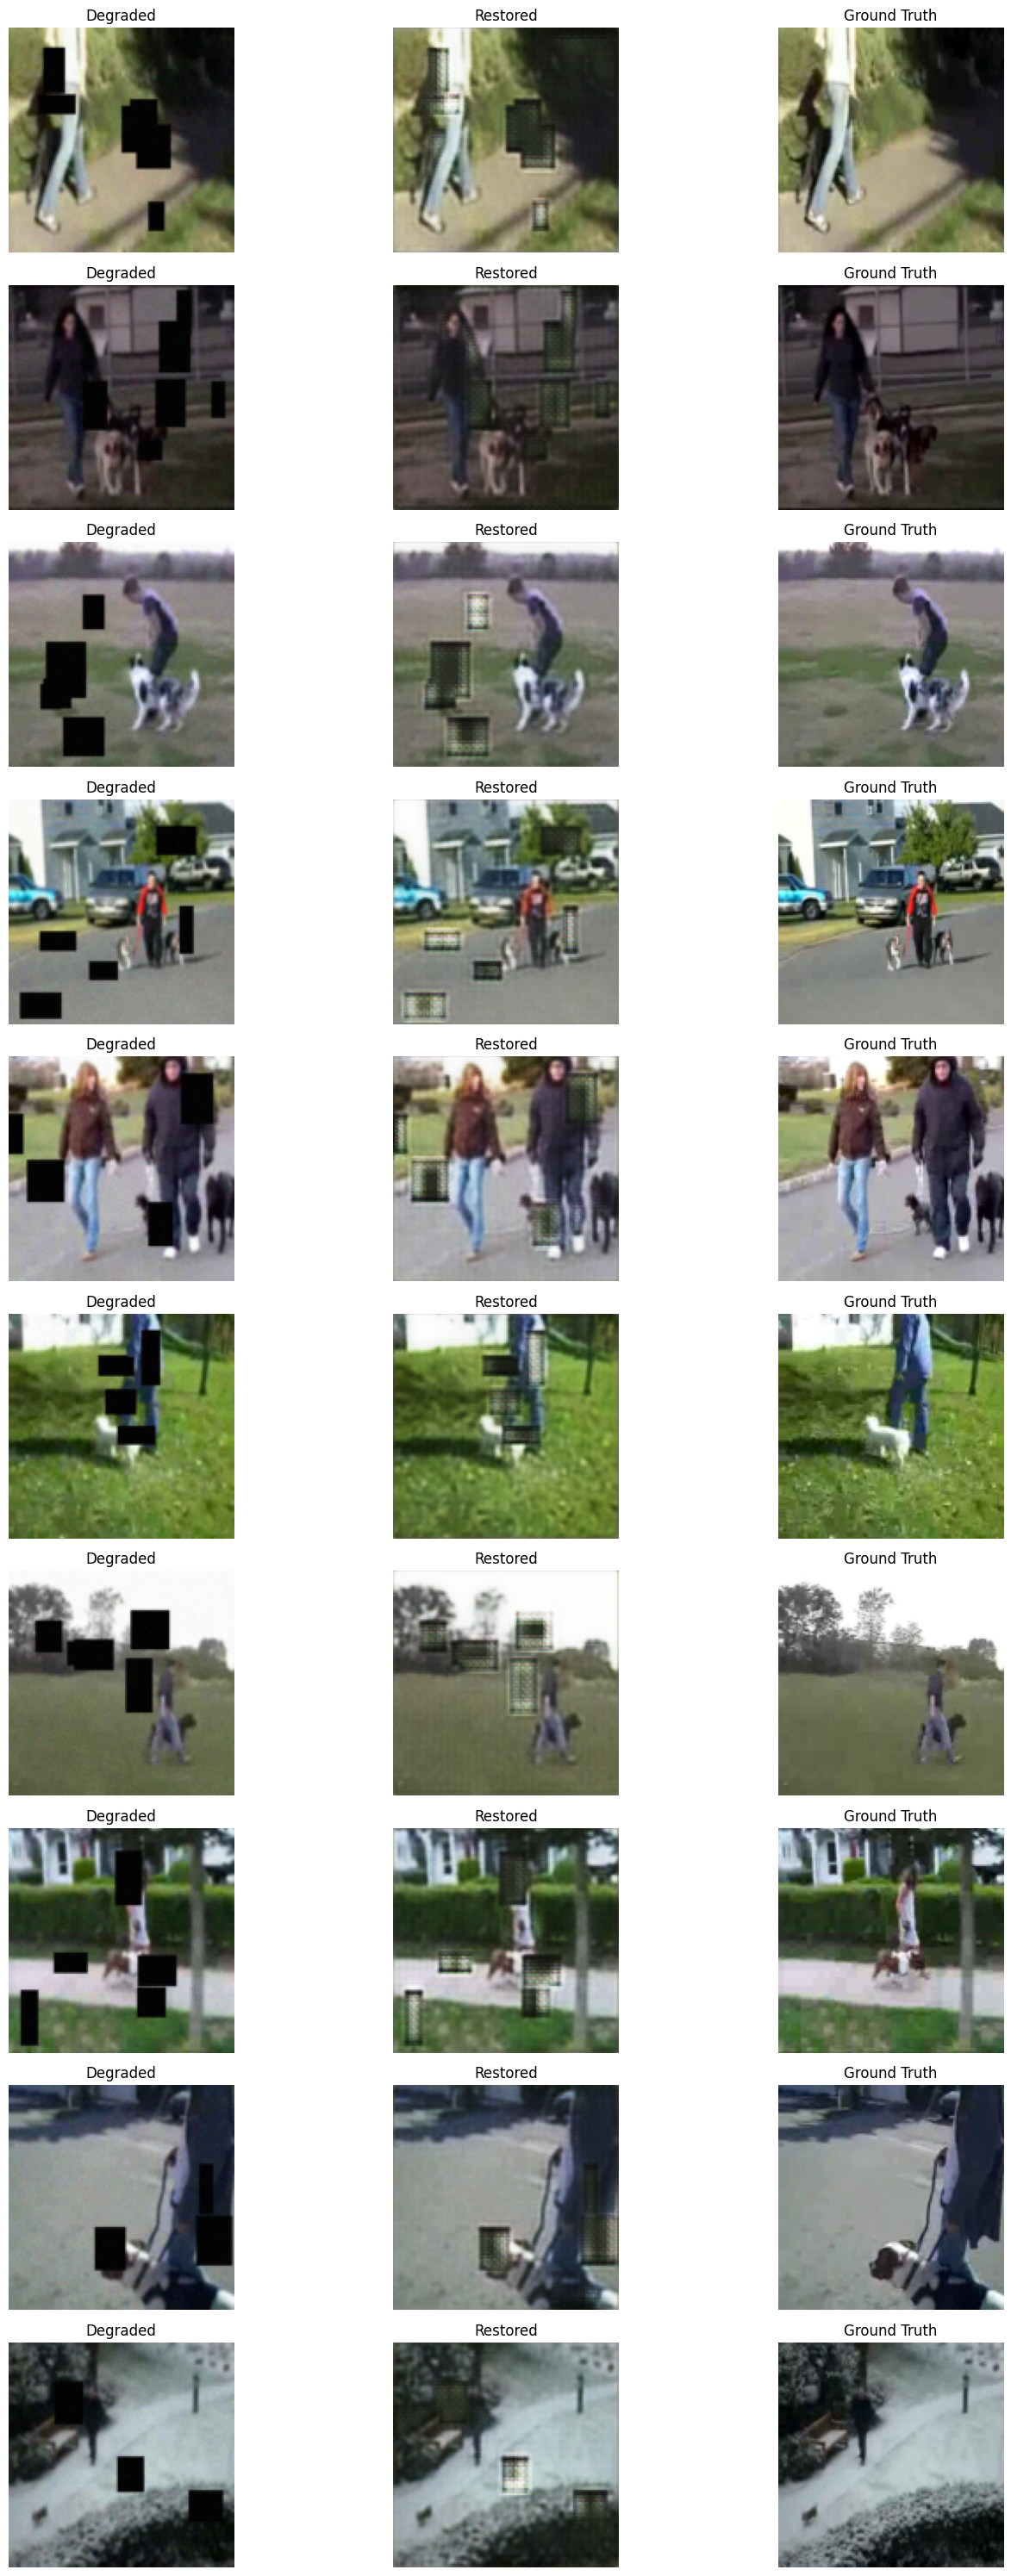

In [ ]:
generator.eval()
samples = random.sample(range(len(dataset)), 10)

plt.figure(figsize=(15, 30))
for i, idx in enumerate(samples):
    degraded_tensor, original_tensor = dataset[idx]
    with torch.no_grad():
        restored_tensor = generator(degraded_tensor.unsqueeze(0).to(device))
    degraded_np = denorm(degraded_tensor)
    restored_np = denorm(restored_tensor)
    original_np = denorm(original_tensor)

    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(degraded_np); plt.title("Degraded"); plt.axis("off")
    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(restored_np); plt.title("Restored"); plt.axis("off")
    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(original_np); plt.title("Ground Truth"); plt.axis("off")

plt.tight_layout()
plt.show()


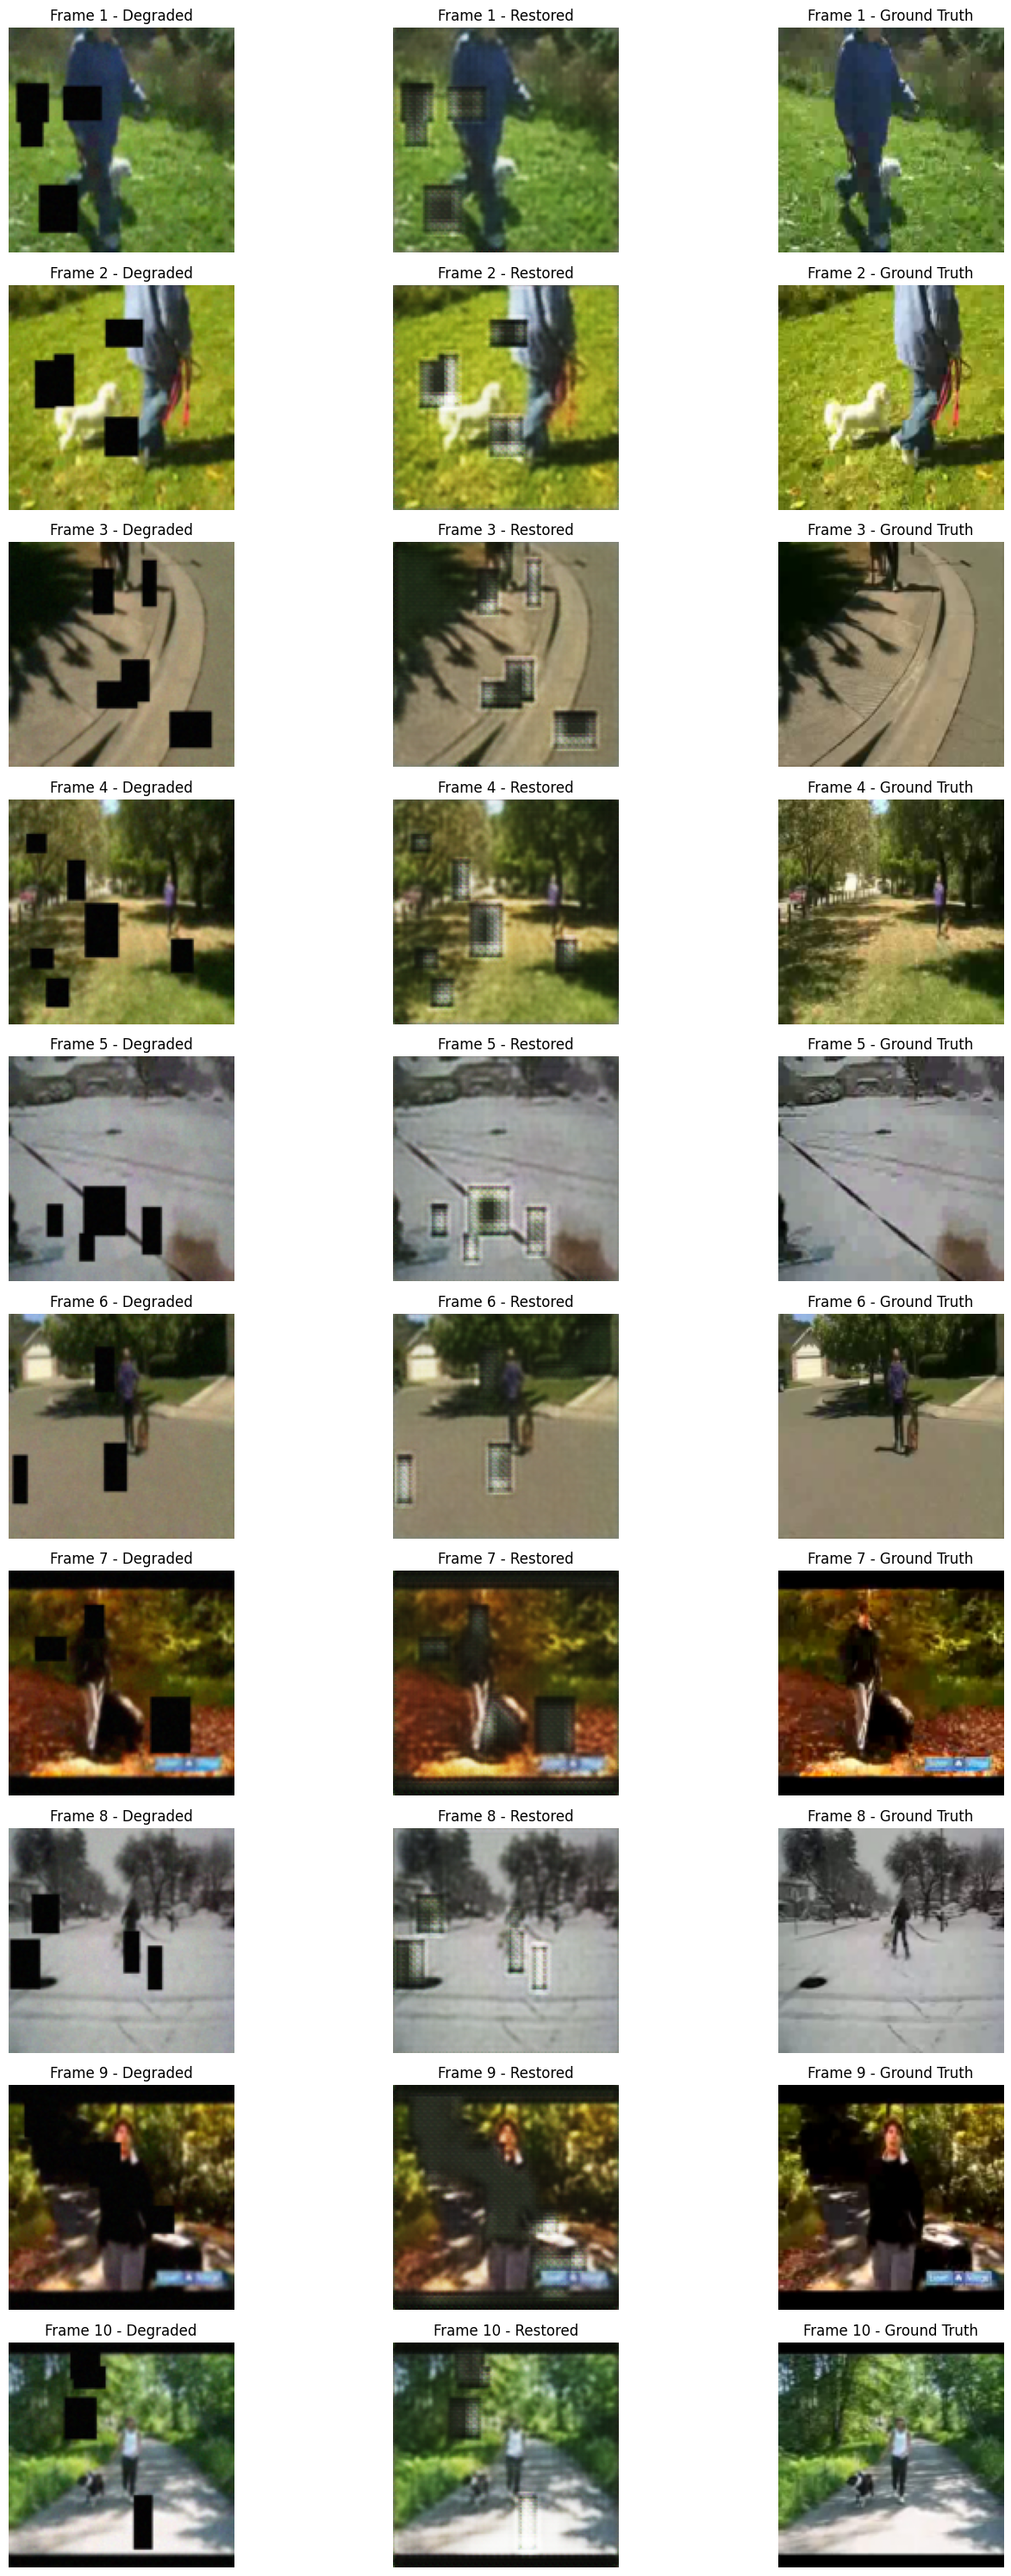

In [ ]:
generator.eval()
video_idx = random.randint(0, len(dataset) - 11)
frames_to_show = []

for i in range(10):
    degraded_tensor, original_tensor = dataset[video_idx + i]
    with torch.no_grad():
        restored_tensor = generator(degraded_tensor.unsqueeze(0).to(device))
    frames_to_show.append((denorm(degraded_tensor), denorm(restored_tensor), denorm(original_tensor)))

plt.figure(figsize=(15, 30))
for i, (d, r, o) in enumerate(frames_to_show):
    plt.subplot(10, 3, i*3 + 1)
    plt.imshow(d); plt.title(f"Frame {i+1} - Degraded"); plt.axis("off")
    plt.subplot(10, 3, i*3 + 2)
    plt.imshow(r); plt.title(f"Frame {i+1} - Restored"); plt.axis("off")
    plt.subplot(10, 3, i*3 + 3)
    plt.imshow(o); plt.title(f"Frame {i+1} - Ground Truth"); plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
generator.eval()
num_samples = 20
samples = random.sample(range(len(dataset)), num_samples)
psnr_before, psnr_after, ssim_before, ssim_after = [], [], [], []

for idx in samples:
    degraded_tensor, original_tensor = dataset[idx]
    with torch.no_grad():
        restored_tensor = generator(degraded_tensor.unsqueeze(0).to(device))

    degraded_np = (denorm(degraded_tensor) * 255).astype(np.uint8)
    restored_np = (denorm(restored_tensor) * 255).astype(np.uint8)
    original_np = (denorm(original_tensor) * 255).astype(np.uint8)

    psnr_before.append(psnr(original_np, degraded_np, data_range=255))
    psnr_after.append(psnr(original_np, restored_np, data_range=255))
    ssim_before.append(ssim(original_np, degraded_np, channel_axis=2, data_range=255))
    ssim_after.append(ssim(original_np, restored_np, channel_axis=2, data_range=255))

print(f"Average PSNR Before Restoration: {np.mean(psnr_before):.2f} dB")
print(f"Average PSNR After Restoration : {np.mean(psnr_after):.2f} dB")
print(f"Average SSIM Before Restoration: {np.mean(ssim_before):.4f}")
print(f"Average SSIM After Restoration : {np.mean(ssim_after):.4f}")


Average PSNR Before Restoration: 17.97 dB
Average PSNR After Restoration : 21.80 dB
Average SSIM Before Restoration: 0.7980
Average SSIM After Restoration : 0.7814


In [ ]:
import cv2
import numpy as np
import os
import glob
from tqdm import tqdm # Import tqdm for the progress bar

# --- Configuration ---
# Make sure these paths are correct for your Google Drive
INPUT_FOLDER = '/content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup'
OUTPUT_FOLDER = '/content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup/degraded_videos'
VIDEO_EXTENSION = '*.avi' # Process all .avi files

# --- NEW: More Aggressive Degradation Parameters ---
SCALE_FACTOR = 0.3  # Drastic resolution loss (30% of original)
BLUR_KERNEL = (11, 11)  # Much stronger blur
NOISE_STD_DEV = 50  # Much more sensor noise
PEPPER_AMOUNT = 0.01  # 1% of all pixels will be turned black (black spots)
# --------------------------------------------------

def add_black_spots(image, amount=0.01):
    """
    Adds "pepper" (black spot) noise to an image.
    """
    row, col, ch = image.shape
    s_vs_p = 1.0  # 1.0 = 100% pepper (black)
    out = np.copy(image)

    # Calculate number of black pixels
    num_pepper = np.ceil(amount * image.size * s_vs_p / ch)

    # Generate random coordinates for the black pixels
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]

    # Set those pixels to black
    out[coords[0], coords[1], :] = 0

    return out

def degrade_video(input_path, output_path):
    """
    Reads a video, applies degradation to each frame,
    and saves it to a new file.
    """

    # 1. Open the input video
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {input_path}")
        return

    # 2. Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Get total frames for progress bar

    # 3. Define the output video writer
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # 4. Loop through all frames with a tqdm progress bar
    # The 'desc' field shows the name of the video being processed
    for _ in tqdm(range(total_frames), desc=f"Processing {os.path.basename(input_path)}"):
        ret, frame = cap.read()
        if not ret:
            break # End of video

        # --- Apply Degradations ---

        # 1. Lower Resolution (Aggressive)
        low_res_dims = (int(width * SCALE_FACTOR), int(height * SCALE_FACTOR))
        degraded_frame = cv2.resize(frame, low_res_dims, interpolation=cv2.INTER_LINEAR)
        degraded_frame = cv2.resize(degraded_frame, (width, height), interpolation=cv2.INTER_LINEAR)

        # 2. Add Gaussian Blur (Aggressive)
        degraded_frame = cv2.GaussianBlur(degraded_frame, BLUR_KERNEL, 0)

        # 3. Add Gaussian Noise (Aggressive)
        noise = np.random.normal(0, NOISE_STD_DEV, degraded_frame.shape).astype(np.float32)
        degraded_frame = np.clip(degraded_frame.astype(np.float32) + noise, 0, 255)
        degraded_frame = degraded_frame.astype(np.uint8)

        # 4. NEW: Add Black Spots
        degraded_frame = add_black_spots(degraded_frame, amount=PEPPER_AMOUNT)

        # ----------------------------
        out.write(degraded_frame)

    # 5. Release everything
    cap.release()
    out.release()
    # No print needed here, tqdm handles the "finished" status

# --- Main script execution ---
if __name__ == "__main__":
    # 1. Create the output folder
    os.makedirs(OUTPUT_FOLDER, exist_ok=True)

    # 2. Find all videos in the input folder
    search_path = os.path.join(INPUT_FOLDER, VIDEO_EXTENSION)
    video_files = glob.glob(search_path)

    if not video_files:
        print(f"No {VIDEO_EXTENSION} files found in {INPUT_FOLDER}.")
        print("Please check your INPUT_FOLDER path and make sure you have mounted your Google Drive.")
    else:
        print(f"Found {len(video_files)} videos to process.")

    # 3. Process each video
    for video_file in video_files:
        file_name = os.path.basename(video_file)
        output_file_path = os.path.join(OUTPUT_FOLDER, file_name)

        # Don't re-process files that are already in the output folder
        if os.path.abspath(video_file) != os.path.abspath(output_file_path):
             degrade_video(video_file, output_file_path)

    print(f"\nAll videos processed. Degraded videos are in: {OUTPUT_FOLDER}")

Found 145 videos to process.


Processing v_ApplyEyeMakeup_g25_c06.avi: 100%|██████████| 109/109 [00:01<00:00, 77.60it/s]


All videos processed. Degraded videos are in: /content/drive/MyDrive/UCF101/UCF-101/ApplyEyeMakeup/degraded_videos


In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr

# --- Ask user for video path ---
input_video_path = input("Enter the path to the original video: ").strip()
degraded_video_path = input("Enter the path to the degraded video: ").strip()

output_video_path = "restored_output.mp4"
model_path = "generator.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load trained model ---
generator = Generator().to(device)
generator.load_state_dict(torch.load(model_path, map_location=device))
generator.eval()

# --- Preprocessing transform ---
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

def denorm(img_tensor):
    img = img_tensor.cpu().squeeze(0) * 0.5 + 0.5
    img_np = np.transpose(img.numpy(), (1, 2, 0))
    return np.clip(img_np, 0, 1)

# --- Read input and degraded videos ---
cap_orig = cv2.VideoCapture(input_video_path)
cap_deg = cv2.VideoCapture(degraded_video_path)

fps = int(cap_deg.get(cv2.CAP_PROP_FPS))
width = int(cap_deg.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap_deg.get(cv2.CAP_PROP_FRAME_HEIGHT))

# --- Output video writer ---
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

psnr_before = []
psnr_after = []
frames_for_display = []

print("🔧 Restoring video and evaluating PSNR...")

while True:
    ret1, orig_frame = cap_orig.read()
    ret2, deg_frame = cap_deg.read()
    if not ret1 or not ret2:
        break

    # Convert to RGB
    orig_rgb = cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB)
    deg_rgb = cv2.cvtColor(deg_frame, cv2.COLOR_BGR2RGB)

    # Transform degraded frame for model input
    frame_pil = Image.fromarray(deg_rgb)
    degraded_tensor = transform(frame_pil).unsqueeze(0).to(device)

    # Generate restored frame
    with torch.no_grad():
        restored_tensor = generator(degraded_tensor)
    restored_np = (denorm(restored_tensor) * 255).astype(np.uint8)

    # --- Add check for valid numpy array before resizing ---
    if not isinstance(restored_np, np.ndarray):
        print(f"Skipping frame due to invalid restored_np type: {type(restored_np)}")
        continue
    # --- End of check ---

    # Resize to original resolution for both display and PSNR
    restored_resized = cv2.resize(restored_np, (width, height))
    restored_bgr = cv2.cvtColor(restored_resized, cv2.COLOR_RGB2BGR)

    # --- PSNR Evaluation (ensure same size) ---
    # Resize degraded frame to match original for PSNR calculation
    deg_rgb_resized = cv2.resize(deg_rgb, (width, height))
    psnr_before.append(psnr(orig_rgb, deg_rgb_resized, data_range=255))
    psnr_after.append(psnr(orig_rgb, restored_resized, data_range=255))

    # --- Write restored frame to output video ---
    out.write(restored_bgr)

    # --- Collect few frames for display ---
    if len(frames_for_display) < 4:
        frames_for_display.append((orig_rgb, deg_rgb_resized, restored_resized)) # Use resized degraded frame for display

cap_orig.release()
cap_deg.release()
out.release()

print(f"✅ Restoration complete! Saved as '{output_video_path}'")
print(f"📉 Average PSNR Before Restoration : {np.mean(psnr_before):.2f} dB")
print(f"📈 Average PSNR After Restoration  : {np.mean(psnr_after):.2f} dB")

# --- Display 3 versions side by side ---
plt.figure(figsize=(15, 9))
for i, (orig, deg, res) in enumerate(frames_for_display):
    plt.subplot(3, len(frames_for_display), i + 1)
    plt.imshow(orig)
    plt.title(f"Original {i+1}")
    plt.axis("off")

    plt.subplot(3, len(frames_for_display), i + 1 + len(frames_for_display))
    plt.imshow(deg)
    plt.title("Degraded")
    plt.axis("off")

    plt.subplot(3, len(frames_for_display), i + 1 + 2 * len(frames_for_display))
    plt.imshow(res)
    plt.title("Restored")
    plt.axis("off")

plt.tight_layout()
plt.show()